# Gradient Boosting

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd

df1 = pd.read_csv('Master_Dataset_LCK_2014-2020v2.csv')

df1["date"] = pd.to_datetime(df1["date"],format="%Y-%m-%d")

df1 = df1.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

df1 = df1.dropna(subset=["date","temperature","ph","salinity","dis_oxy"])

df1 = df1.drop_duplicates()

Q1 = df1['temperature'].quantile(0.25)
Q3 = df1['temperature'].quantile(0.75)
IQR = Q3 - Q1
tp_lower_bound = Q1 - 2.0 * IQR
tp_upper_bound = Q3 + 2.0 * IQR
df1 = df1[(df1['temperature'] >= tp_lower_bound) & (df1['temperature'] <= tp_upper_bound)]
df1["Temperature Category"] = ""
df1.loc[df1["temperature"] > 23, "Temperature Category"] = "Hot"
df1.loc[(df1["temperature"] >= 19) & (df1["temperature"] <= 23), "Temperature Category"] = "Warm"
df1.loc[df1["temperature"] < 19, "Temperature Category"] = "Cold"

Q1 = df1['dis_oxy'].quantile(0.25)
Q3 = df1['dis_oxy'].quantile(0.75)
IQR = Q3 - Q1
dis_lower_bound = Q1 - 2.0 * IQR
dis_upper_bound = Q3 + 2.0 * IQR
df1 = df1[(df1['dis_oxy'] >= dis_lower_bound) & (df1['dis_oxy'] <= dis_upper_bound)]
df1["o1"] = ""
df1.loc[df1["dis_oxy"] > 6.7, "o1"] = "High"
df1.loc[(df1["dis_oxy"] >= 6.4) & (df1["dis_oxy"] <= 6.7), "o1"] = "Mild"
df1.loc[df1["dis_oxy"] < 6.4, "o1"] = "Low"


Q1 = df1['ph'].quantile(0.25)
Q3 = df1['ph'].quantile(0.75)
IQR = Q3 - Q1
ph_lower_bound = Q1 - 2.0 * IQR
ph_upper_bound = Q3 + 2.0 * IQR
df1 = df1[(df1['ph'] >= ph_lower_bound) & (df1['ph'] <= ph_upper_bound)]

print(df1.head(10))

      id              name        type   latitude   longitude       date  \
0  SC-N1   CARCAMO MALECON     CONTROL  26.013386 -111.339279 2014-01-02   
1   SCS1  PUERTO ESCONDIDO     CONTROL  25.814849 -111.312320 2014-01-02   
2   SEN1     LA CANDELARIA      ESTERO  26.025014 -111.344708 2014-01-02   
3   SES1     ESTERO NOPOLO  RECREATIVO  25.930998 -111.356266 2014-01-02   
4   SRN1      LOS PANGONES  RECREATIVO  25.972378 -111.352629 2014-01-02   
5   SRN2        LA DARSENA  RECREATIVO  26.016500 -111.340808 2014-01-02   
6   SRN4        LA NEGRITA  RECREATIVO  26.022352 -111.344335 2014-01-02   
7   SRN5        MIL PALMAS  RECREATIVO  26.058156 -111.328300 2014-01-02   
8   SRN6        LA PICAZON  RECREATIVO  26.082873 -111.323868 2014-01-02   
9   SRS1   ENSENADA BLANCA  RECREATIVO  25.721483 -111.234901 2014-01-02   

       hour         timestamp  temperature  salinity    ph  dis_oxy  \
0  13:00:00  2014-01-02 13:00        19.95      31.8  7.69     6.08   
1  10:17:00  2014-01-

In [17]:
print(df1["dis_oxy"].describe())
df1.columns.get_loc("ph")

count    2595.000000
mean        6.524555
std         0.556781
min         4.210000
25%         6.080000
50%         6.330000
75%         6.900000
max         9.920000
Name: dis_oxy, dtype: float64


9

In [3]:
# Import models and utility functions
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score,f1_score,classification_report, roc_curve,roc_auc_score
from sklearn.datasets import load_digits

# Setting SEED for reproducibility
SEED = 23
 
# Importing the dataset 
X = df1[["ph","dis_oxy","salinity"]]
X = pd.DataFrame(X,columns=["ph","dis_oxy","salinity"])
Y = df1["Temperature Category"]
 
# Splitting dataset
train_X, test_X, train_y, test_y = train_test_split(X, Y, 
                                                    test_size = 0.25, 
                                                    random_state = 123)
# Instantiate Gradient Boosting Classifer
gbc = GradientBoostingClassifier(n_estimators=1000,
                                 learning_rate=0.05,
                                 random_state=100,
                                 max_features=5 )

# Fit to training set
gbc.fit(train_X, train_y)
 
# # Predict on test set
pred_y = gbc.predict(test_X)
 
# # accuracy
acc = accuracy_score(test_y, pred_y)
print("Gradient Boosting Classifier accuracy is : {:.2f}".format(acc))

# # confusion matrix
## A confusion matrix provides a more detailed view of the model's performance,
## showing the number of true positives, true negatives, false positives, and false negatives.
cfsn = confusion_matrix(test_y, pred_y)
print("Confusion matrix is : \n",(cfsn))

# # precision,recall,f1
## add average=None if value error
precision = precision_score(test_y,pred_y,average=None)
recall = recall_score(test_y,pred_y,average=None)
f1 = f1_score(test_y,pred_y,average=None)
print("Precision: \n", precision)
print("Recall: \n", recall)
print("F1-Score: \n", f1)

# # Classification Report
## The classification_report function in scikit-learn provides a summary of 
## precision, recall, F1-score, and support for each class.
report = classification_report(test_y,pred_y)
print("Classification Report: \n", report)

# # Receiver Operating Characteristic (ROC) Curve and Area Under the Curve (AUC):
## These metrics are useful when dealing with binary classification and 
## measuring the model's ability to discriminate between classes.
## need predicted_probs
# fpr, tpr, thresholds = roc_curve(test_y, predicted_probs)
# auc = roc_auc_score(test_y, predicted_probs)

day1=[1,2,3]
day2=[2,3,4]
day3=[9,8,7]
day4=[1,2,3]
new_data= pd.DataFrame(np.array([day1,day2,day3,day4]),columns=["ph","dis_oxy","salinity"])
new_pred=gbc.predict(new_data)
print(new_pred)

Gradient Boosting Classifier accuracy is : 0.88
Confusion matrix is : 
 [[ 62   4  10]
 [  5 402  12]
 [ 15  30 106]]
Precision: 
 [0.75609756 0.92201835 0.828125  ]
Recall: 
 [0.81578947 0.95942721 0.70198675]
F1-Score: 
 [0.78481013 0.94035088 0.75985663]
Classification Report: 
               precision    recall  f1-score   support

        Cold       0.76      0.82      0.78        76
         Hot       0.92      0.96      0.94       419
        Warm       0.83      0.70      0.76       151

    accuracy                           0.88       646
   macro avg       0.84      0.83      0.83       646
weighted avg       0.88      0.88      0.88       646

['Warm' 'Warm' 'Cold' 'Warm']


# LSTM for One factor

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd

df1 = pd.read_csv('Master_Dataset_LCK_2014-2020v2.csv')

df1["date"] = pd.to_datetime(df1["date"],format="%Y-%m-%d")

df1 = df1.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

df1 = df1.dropna(subset=["date","temperature","ph","salinity","dis_oxy"])

df1 = df1.drop_duplicates()

## lstm for ph
df1.sort_values(by="date")

## create sequence used for lstm
# df1.set_index('date', inplace=True)
sequence_length = 10
input_sequences = []
target_sequences = []

for i in range(len(df1) - sequence_length):
    X_seq = df1["ph"].values[i]
    Y_seq = df1["ph"].values[i+sequence_length]
    X_dates = df1["date"].values[i]
    input_sequences.append({"dates":X_dates,"ph":X_seq})
    target_sequences.append(df1.iloc[i+sequence_length,9])
    
# Convert the lists to DataFrames if needed
X_sequences_df = pd.DataFrame(input_sequences)
Y_sequences_df = pd.Series(target_sequences, name='ph_target')

# Now you have X_sequences_df containing sequences of 'ph' values with dates and y_sequences_df with target values.


X_train, X_test, Y_train, Y_test = train_test_split(
    X_sequences_df, Y_sequences_df, test_size=0.2, shuffle=False,random_state=42)


##LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Initialize the model
model = Sequential()

# Add an LSTM layer with the input shape matching your sequence length
model.add(LSTM(50, input_shape=(sequence_length, 1)))

# Add a Dense output layer with one unit for regression
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')  # Use appropriate loss function

model.fit(X_train['ph'], Y_train, epochs=20, batch_size=32)  # Adjust the number of epochs and batch size
## batch_size -> 32,64,128

# Evaluate the model on the test data
loss = model.evaluate(X_test['ph'], Y_test)
print(f'Mean Squared Error on Test Data: {loss}')


Epoch 1/20
65/65 [==============================] - 1s 1ms/step - loss: 1013.0592
Epoch 2/20
65/65 [==============================] - 0s 1ms/step - loss: 867.9497
Epoch 3/20
65/65 [==============================] - 0s 1ms/step - loss: 693.8325
Epoch 4/20
65/65 [==============================] - 0s 1ms/step - loss: 523.5256
Epoch 5/20
65/65 [==============================] - 0s 1ms/step - loss: 372.2160
Epoch 6/20
65/65 [==============================] - 0s 1ms/step - loss: 250.0955
Epoch 7/20
65/65 [==============================] - 0s 1ms/step - loss: 162.2818
Epoch 8/20
65/65 [==============================] - 0s 1ms/step - loss: 100.9926
Epoch 9/20
65/65 [==============================] - 0s 1ms/step - loss: 62.1218
Epoch 10/20
65/65 [==============================] - 0s 1ms/step - loss: 38.2824
Epoch 11/20
65/65 [==============================] - 0s 1ms/step - loss: 23.5748
Epoch 12/20
65/65 [==============================] - 0s 1ms/step - loss: 14.5828
Epoch 13/20
65/65 [=========

In [47]:
df1["ph"].values[-2:]
initial_sequence = df1["ph"].values[-sequence_length:]
print(initial_sequence)

[6.98 7.2  7.2  7.2  7.2  7.2  7.2  7.2  7.2  7.2 ]


In [79]:
# Initialize an empty sequence to start the prediction
initial_sequence = df1["ph"].values[-sequence_length:]  # Use the last sequence_length data points from your historical data

# Initialize a list to store the predicted data
predicted_data = list(initial_sequence)

# Number of future time steps to predict (e.g., 10 years with monthly data)
num_steps_to_predict = 100 # Adjust as needed

for step in range(num_steps_to_predict):
    sequence_length=len(initial_sequence)
    # Reshape the initial_sequence for the model's input shape
    #reshape (batch_size,sequence_length,numberoffeature)
    input_data = np.array(initial_sequence).reshape(1, sequence_length, 1)
    
    # Predict the next data point
    next_data_point = model.predict(input_data)
    
    # Append the prediction to the predicted_data
    predicted_data.append(next_data_point[0, 0])  # Assuming a single-value output
    
    # Update the initial_sequence for the next prediction
    initial_sequence = initial_sequence[1:] + [next_data_point[0, 0]]

print(len(initial_sequence))
print(sequence_length)
print("predict how much: ",len(predicted_data)-len(initial_sequence))
## new 24 datas (but only step for 12 so last 12 is wrong one)
## need to remove last -number_of_steps
predicted_data = predicted_data[:-num_steps_to_predict]
print("predict how much?: ",len(predicted_data)-len(initial_sequence))
print("last ",num_steps_to_predict,": ",predicted_data[-num_steps_to_predict:])
# The predicted_data list now contains the predictions for the next 10 years

1/1 [==============================] - 0s 62ms/step
2341
2342
predict how much:  200
predict how much?:  100
last  100 :  [7.35, 7.35, 7.35, 7.35, 7.35, 7.35, 7.35, 7.35, 7.35, 7.35, 6.92, 6.92, 6.92, 6.92, 6.92, 6.92, 6.92, 6.92, 6.92, 6.92, 6.92, 6.92, 6.92, 6.92, 6.92, 6.92, 6.92, 6.92, 6.92, 6.92, 6.92, 6.92, 6.92, 6.92, 7.21, 7.21, 7.21, 7.21, 7.21, 7.21, 7.21, 7.21, 7.21, 7.21, 7.21, 7.21, 6.96, 6.96, 6.96, 6.96, 6.96, 6.96, 7.21, 7.21, 7.21, 7.21, 7.21, 7.21, 7.21, 7.21, 7.21, 7.21, 7.21, 7.21, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 6.98, 6.98, 6.98, 6.98, 6.98, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2]


# Link to google

In [ ]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

# Use the credentials JSON file you obtained earlier
credentials = ServiceAccountCredentials.from_json_keyfile_name('22621.1702.230505-1222.ni_release_svc_refresh_CLIENTCONSUMER_RET_A64FRE_en-us.json', ['https://docs.google.com/spreadsheets/d/1CCAIYfN15RJut44TbjeTvi6Lcznyrfga1Q39DgIgDeo/edit#gid=0'])
gc = gspread.authorize(credentials)

# Open a Google Sheet by title
worksheet = gc.open('Your Google Sheet Title').sheet1

# Now you can add data to the sheet
# For example, you can use Pandas to export a DataFrame
import pandas as pd
df = pd.DataFrame(your_data)
worksheet.update([df.columns.values.tolist()] + df.values.tolist())

In [33]:
newph = float(input("newph: "))
newdisl = float(input("newdis: "))
newsal = float(input("newsal: "))
newday=[newph,newdisl,newsal]
new_data= pd.DataFrame(np.array([newday]),columns=["ph","dis_oxy","salinity"])
new_pred=gbc.predict(new_data)
print(new_pred)

newph: 3
newdis: 4
newsal: 5
['Warm']


In [67]:
# Notes
# Able to input dataset
# cleaning data
# start gradient boosting
# X = df[["F1","F2","F3"]]
# Y = df["Result"]
# train_test_split(X,Y,test_size=k (how many %k used to test),random_state=(a random number that used to keep track only so any number will do))
# gbc = GradientBoostingClassifer(n_esitmators,learning rate,random_state, max features)

# n_estimators -> number of weak learners(if set 300, then gbc use 300 decision tree)
# learning rate -> control contribution of each week learner to overall prediction (lowers LR need more weak learner to achieve same accuracy)
# random_state -> seed
# max_features -> maximum numbers of features that be considered when spliting a node in each decision tree (control complexity of individual trees)
# ** Can tune hyperparameters learning rate and max_features

# later use gbc.fit(trainX,trainY)

# pred_y = gbc.predict(test_X) 找accuracy

# later can predict new data's result already

# SVM (Support Vector Machine)

In [13]:
# find the best line separate two classes and 
# the margin within the line 

# the wider the margin, the better the separation of two or more classes
# SVM predicts which side of the gap the new sample will fall

#sensitive to scale so need to have same scale

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd

df1 = pd.read_csv('Master_Dataset_LCK_2014-2020v2.csv')

df1["date"] = pd.to_datetime(df1["date"],format="%Y-%m-%d")

df1 = df1.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

df1 = df1.dropna(subset=["date","temperature","ph","salinity","dis_oxy"])

df1 = df1.drop_duplicates()

Q1 = df1['temperature'].quantile(0.25)
Q3 = df1['temperature'].quantile(0.75)
IQR = Q3 - Q1
tp_lower_bound = Q1 - 2.0 * IQR
tp_upper_bound = Q3 + 2.0 * IQR
df1 = df1[(df1['temperature'] >= tp_lower_bound) & (df1['temperature'] <= tp_upper_bound)]
df1["Temperature Category"] = ""
df1.loc[df1["temperature"] > 23, "Temperature Category"] = "Hot"
df1.loc[(df1["temperature"] >= 19) & (df1["temperature"] <= 23), "Temperature Category"] = "Warm"
df1.loc[df1["temperature"] < 19, "Temperature Category"] = "Cold"

Q1 = df1['dis_oxy'].quantile(0.25)
Q3 = df1['dis_oxy'].quantile(0.75)
IQR = Q3 - Q1
dis_lower_bound = Q1 - 2.0 * IQR
dis_upper_bound = Q3 + 2.0 * IQR
df1 = df1[(df1['dis_oxy'] >= dis_lower_bound) & (df1['dis_oxy'] <= dis_upper_bound)]
df1["o1"] = ""
df1.loc[df1["dis_oxy"] > 6.7, "o1"] = "High"
df1.loc[(df1["dis_oxy"] >= 6.4) & (df1["dis_oxy"] <= 6.7), "o1"] = "Mild"
df1.loc[df1["dis_oxy"] < 6.4, "o1"] = "Low"


Q1 = df1['ph'].quantile(0.25)
Q3 = df1['ph'].quantile(0.75)
IQR = Q3 - Q1
ph_lower_bound = Q1 - 2.0 * IQR
ph_upper_bound = Q3 + 2.0 * IQR
df1 = df1[(df1['ph'] >= ph_lower_bound) & (df1['ph'] <= ph_upper_bound)]


In [46]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score,f1_score,classification_report, roc_curve,roc_auc_score


##scale them to normal
x=df1["ph"]
x = (x-min(x))/(max(x)-min(x))

x1=x.values.reshape(-1,1)
scaler = MinMaxScaler()
scaled_ph = scaler.fit_transform(x1)
df1["ph"]=scaled_ph

x=df1["dis_oxy"]
x = (x-min(x))/(max(x)-min(x))

x1=x.values.reshape(-1,1)
scaler = MinMaxScaler()
scaled_ph = scaler.fit_transform(x1)
df1["dis_oxy"]=scaled_ph

x=df1["salinity"]
x = (x-min(x))/(max(x)-min(x))

x1=x.values.reshape(-1,1)
scaler = MinMaxScaler()
scaled_ph = scaler.fit_transform(x1)
df1["salinity"]=scaled_ph
####

X = df1[["ph","dis_oxy","salinity"]]
X = pd.DataFrame(X,columns=["ph","dis_oxy","salinity"])
Y = df1["Temperature Category"]

train_X, test_X, train_y, test_y = train_test_split(X, Y, 
                                                    test_size = 0.25, 
                                                    random_state = 123)

svc = SVC(kernel="poly",degree=3,coef0=1,C=1.0)
svc.fit(train_X,train_y)
y_pred=svc.predict(test_X)

print(accuracy_score(test_y,y_pred))

print(test_X,test_y)

#normalize increase accuracy from (rbf)0.60-> 0.67
# poly degree =4 -> 0.68

0.7120743034055728
            ph   dis_oxy  salinity
2501  0.188172  0.328125  0.746575
1418  0.118280  0.578125  0.753425
1172  0.354839  0.364583  0.821918
2433  0.150538  0.367188  0.664384
2485  0.188172  0.328125  0.924658
...        ...       ...       ...
1620  0.293011  0.346354  0.787671
2545  0.293011  0.346354  0.671233
1234  0.209677  0.320313  0.979452
2312  0.118280  0.578125  0.787671
2166  0.881720  0.955729  0.938356

[646 rows x 3 columns] 2501     Hot
1418     Hot
1172    Cold
2433     Hot
2485     Hot
        ... 
1620     Hot
2545     Hot
1234    Cold
2312     Hot
2166    Warm
Name: Temperature Category, Length: 646, dtype: object


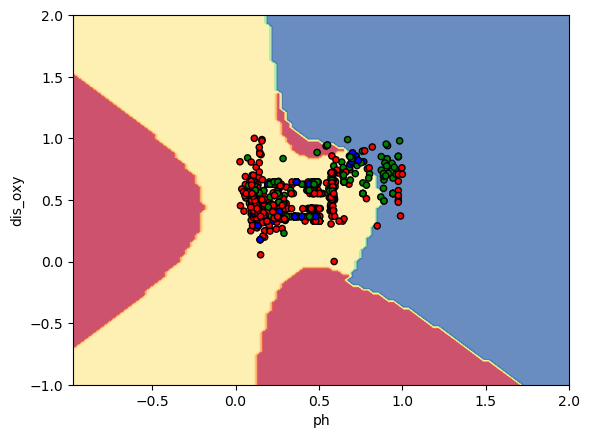

In [47]:
#this graph only accept 2 features
X = df1[["ph","dis_oxy"]]
X = pd.DataFrame(X,columns=["ph","dis_oxy"])
Y = df1["Temperature Category"]

train_X, test_X, train_y, test_y = train_test_split(X, Y, 
                                                    test_size = 0.25, 
                                                    random_state = 123)

svc = SVC(kernel="poly",degree=3,coef0=1,C=1.0)
svc.fit(train_X,train_y)
y_pred=svc.predict(test_X)
###########


import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay

display = DecisionBoundaryDisplay.from_estimator(
        svc,
        train_X,
        response_method="predict",
        cmap=plt.cm.Spectral,
        alpha=0.8
    )

#c must be colour so label each class with color#
class_labels = ["Warm","Hot","Cold"]  # Adjust these to match your actual class labels
class_colors = ['g', 'r', 'b']  # Adjust these to specify the colors for each class
colors = [class_colors[class_labels.index(label)] for label in train_y]
##

plt.scatter(train_X[["ph"]],train_X[["dis_oxy"]], 
            c=colors, 
            s=20, edgecolors="k")
plt.show()

#Green warm, Hot red, Cold blue
#Red Yellor Blue is Decision boundary

# Multivariate Linear Regression (numeric value)

In [34]:
df1 = pd.read_csv('Master_Dataset_LCK_2014-2020v2.csv')

df1["date"] = pd.to_datetime(df1["date"],format="%Y-%m-%d")

df1 = df1.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

df1 = df1.dropna(subset=["date","temperature","ph","salinity","dis_oxy"])

df1 = df1.drop_duplicates()

Q1 = df1['temperature'].quantile(0.25)
Q3 = df1['temperature'].quantile(0.75)
IQR = Q3 - Q1
tp_lower_bound = Q1 - 2.0 * IQR
tp_upper_bound = Q3 + 2.0 * IQR
df1 = df1[(df1['temperature'] >= tp_lower_bound) & (df1['temperature'] <= tp_upper_bound)]

Q1 = df1['dis_oxy'].quantile(0.25)
Q3 = df1['dis_oxy'].quantile(0.75)
IQR = Q3 - Q1
dis_lower_bound = Q1 - 2.0 * IQR
dis_upper_bound = Q3 + 2.0 * IQR
df1 = df1[(df1['dis_oxy'] >= dis_lower_bound) & (df1['dis_oxy'] <= dis_upper_bound)]
df1["o1"] = ""
df1.loc[df1["dis_oxy"] > 6.7, "o1"] = "High"
df1.loc[(df1["dis_oxy"] >= 6.4) & (df1["dis_oxy"] <= 6.7), "o1"] = "Mild"
df1.loc[df1["dis_oxy"] < 6.4, "o1"] = "Low"


Q1 = df1['ph'].quantile(0.25)
Q3 = df1['ph'].quantile(0.75)
IQR = Q3 - Q1
ph_lower_bound = Q1 - 2.0 * IQR
ph_upper_bound = Q3 + 2.0 * IQR
df1 = df1[(df1['ph'] >= ph_lower_bound) & (df1['ph'] <= ph_upper_bound)]



In [48]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,roc_auc_score

X = df1[["ph","dis_oxy","salinity"]]
X = pd.DataFrame(X,columns=["ph","dis_oxy","salinity"])
Y = df1["temperature"]
 
# Splitting dataset
train_X, test_X, train_y, test_y = train_test_split(X, Y, 
                                                    test_size = 0.25, 
                                                    random_state = 123)

model = LinearRegression()
model.fit(train_X, train_y)

Y_pred = model.predict(test_X)

# Evaluate the model
mse = mean_squared_error(test_y, Y_pred)
r_squared = r2_score(test_y, Y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r_squared) #so low

# Interpret the coefficients
coefficients = model.coef_
intercept = model.intercept_
print("Coefficients:", coefficients)
print("Intercept:", intercept)

## need to convert to binary to use roc auc
##print("ROC: ",roc_auc_score(test_y,Y_pred))

#print("Accuracy : ",accuracy_score(test_y,Y_pred))
#accuracy only for classification
#classification -> predict a categorical label or class
# output is discrete
#regression -> predict a continuous numeric value
# output is real number


Mean Squared Error: 20.696071807525065
R-squared: 0.13570477219092214
Coefficients: [  1.7551265  -14.38639865  -0.33056734]
Intercept: 31.980357193389196


# Decision Tree

In [36]:
df1["Temperature Category"] = ""
df1.loc[df1["temperature"] > 23, "Temperature Category"] = "Hot"
df1.loc[(df1["temperature"] >= 19) & (df1["temperature"] <= 23), "Temperature Category"] = "Warm"
df1.loc[df1["temperature"] < 19, "Temperature Category"] = "Cold"

X = df1[["ph","dis_oxy","salinity"]]
X = pd.DataFrame(X,columns=["ph","dis_oxy","salinity"])
Y = df1["Temperature Category"]
 
# Splitting dataset
train_X, test_X, train_y, test_y = train_test_split(X, Y, 
                                                    test_size = 0.25, 
                                                    random_state = 123)

from sklearn.tree import DecisionTreeClassifier
d=DecisionTreeClassifier()
d.fit(train_X,train_y)
y_pred=d.predict(test_X)

print(accuracy_score(test_y,y_pred))

0.8637770897832817


# Random Forest

In [37]:
df1["Temperature Category"] = ""
df1.loc[df1["temperature"] > 23, "Temperature Category"] = "Hot"
df1.loc[(df1["temperature"] >= 19) & (df1["temperature"] <= 23), "Temperature Category"] = "Warm"
df1.loc[df1["temperature"] < 19, "Temperature Category"] = "Cold"

X = df1[["ph","dis_oxy","salinity"]]
X = pd.DataFrame(X,columns=["ph","dis_oxy","salinity"])
Y = df1["Temperature Category"]
 
# Splitting dataset
train_X, test_X, train_y, test_y = train_test_split(X, Y, 
                                                    test_size = 0.25, 
                                                    random_state = 123)

from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf.fit(train_X,train_y)
y_pred=rf.predict(test_X)

print(accuracy_score(test_y,y_pred))

0.891640866873065


# Logistic Regression

In [50]:
df1 = pd.read_csv('Master_Dataset_LCK_2014-2020v2.csv')

df1["date"] = pd.to_datetime(df1["date"],format="%Y-%m-%d")

df1 = df1.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

df1 = df1.dropna(subset=["date","temperature","ph","salinity","dis_oxy"])

df1 = df1.drop_duplicates()

Q1 = df1['temperature'].quantile(0.25)
Q3 = df1['temperature'].quantile(0.75)
IQR = Q3 - Q1
tp_lower_bound = Q1 - 2.0 * IQR
tp_upper_bound = Q3 + 2.0 * IQR
df1 = df1[(df1['temperature'] >= tp_lower_bound) & (df1['temperature'] <= tp_upper_bound)]

Q1 = df1['dis_oxy'].quantile(0.25)
Q3 = df1['dis_oxy'].quantile(0.75)
IQR = Q3 - Q1
dis_lower_bound = Q1 - 2.0 * IQR
dis_upper_bound = Q3 + 2.0 * IQR
df1 = df1[(df1['dis_oxy'] >= dis_lower_bound) & (df1['dis_oxy'] <= dis_upper_bound)]
df1["o1"] = ""
df1.loc[df1["dis_oxy"] > 6.7, "o1"] = "High"
df1.loc[(df1["dis_oxy"] >= 6.4) & (df1["dis_oxy"] <= 6.7), "o1"] = "Mild"
df1.loc[df1["dis_oxy"] < 6.4, "o1"] = "Low"


Q1 = df1['ph'].quantile(0.25)
Q3 = df1['ph'].quantile(0.75)
IQR = Q3 - Q1
ph_lower_bound = Q1 - 2.0 * IQR
ph_upper_bound = Q3 + 2.0 * IQR
df1 = df1[(df1['ph'] >= ph_lower_bound) & (df1['ph'] <= ph_upper_bound)]



In [51]:
df1["Temperature Category"] = ""
df1.loc[df1["temperature"] > 23, "Temperature Category"] = "Hot"
df1.loc[(df1["temperature"] >= 19) & (df1["temperature"] <= 23), "Temperature Category"] = "Warm"
df1.loc[df1["temperature"] < 19, "Temperature Category"] = "Cold"

X = df1[["ph","dis_oxy","salinity"]]
X = pd.DataFrame(X,columns=["ph","dis_oxy","salinity"])
Y = df1["Temperature Category"]
 
# Splitting dataset
train_X, test_X, train_y, test_y = train_test_split(X, Y, 
                                                    test_size = 0.25, 
                                                    random_state = 123)

from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(train_X,train_y)
y_pred=lr.predict(test_X)

print(accuracy_score(test_y,y_pred))


0.6439628482972136


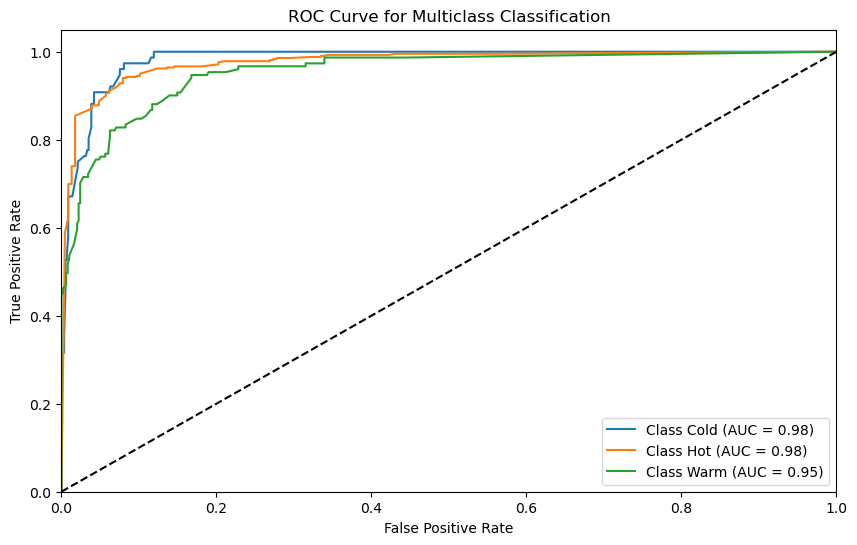

In [52]:
from sklearn import metrics
import matplotlib.pyplot as plt

# Create and fit your classifier (replace with your chosen classifier)
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(train_X, train_y)

# Get predicted probabilities for each class
y_prob = classifier.predict_proba(test_X)

# Calculate ROC curves for each class separately
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(classifier.classes_)  # Number of classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(test_y == classifier.classes_[i], y_prob[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {classifier.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc='best')
plt.show()


# only accept numeric values
# test_auc = roc_auc_score(test_y,y_pred)
# print("Test ROC-AUC: ",test_auc)

#auc ->1 excellent, perfect classifier

# LSTM

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler

df1 = pd.read_csv('Master_Dataset_LCK_2014-2020v2.csv')
df1["date"] = pd.to_datetime(df1["date"],format="%Y-%m-%d")
df1 = df1.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df1 = df1.dropna(subset=["date","temperature","ph","salinity","dis_oxy"])
df1 = df1.drop_duplicates()
Q1 = df1['temperature'].quantile(0.25)
Q3 = df1['temperature'].quantile(0.75)
IQR = Q3 - Q1
tp_lower_bound = Q1 - 2.0 * IQR
tp_upper_bound = Q3 + 2.0 * IQR
df1 = df1[(df1['temperature'] >= tp_lower_bound) & (df1['temperature'] <= tp_upper_bound)]
Q1 = df1['dis_oxy'].quantile(0.25)
Q3 = df1['dis_oxy'].quantile(0.75)
IQR = Q3 - Q1
dis_lower_bound = Q1 - 2.0 * IQR
dis_upper_bound = Q3 + 2.0 * IQR
df1 = df1[(df1['dis_oxy'] >= dis_lower_bound) & (df1['dis_oxy'] <= dis_upper_bound)]
Q1 = df1['ph'].quantile(0.25)
Q3 = df1['ph'].quantile(0.75)
IQR = Q3 - Q1
ph_lower_bound = Q1 - 2.0 * IQR
ph_upper_bound = Q3 + 2.0 * IQR
df1 = df1[(df1['ph'] >= ph_lower_bound) & (df1['ph'] <= ph_upper_bound)]



# Harmful Algal Bloom dataset from fisheries

In [5]:
import xml.etree.ElementTree as ET

tree = ET.parse('1/HarmfulAlgalBlooms.xml')
root = tree.getroot()

# You can navigate the XML tree, extract data, and modify it.
for element in root:
    print(element.tag, element.text)

idinfo 
    
dataqual 
    
spdoinfo 
    
spref 
    
eainfo 
    
distinfo 
    
metainfo 
    


In [9]:
import fiona

# gdb -> geodatabase
#lyr file must in gdb file (no need 1/ auto find the same file)
# Open the GDB file
with fiona.open("1/HarmfulAlgalBlooms.gdb", layer='HarmfulAlgalBlooms') as src:
    for feature in src:
        # Process each feature
        print(feature)

In [12]:
import geopandas as gpd

gdb_path = '1/HarmfulAlgalBlooms.gdb'  # Update with your GDB path
layer_name = 'HarmfulAlgalBlooms'  # Update with your layer name

gdf = gpd.read_file(gdb_path, layer=layer_name)

In [13]:
df = gdf.drop(columns='geometry')

In [16]:
print(df)

      OBJECTID  Id GRID_ID  F2000  F2001  F2002  F2003  F2004  F2005  F2006  \
0            1   0  ZL-247      0      0      0      0      0      0      0   
1            2   0  WN-244      0      0      0      0      0      0      0   
2            3   0  YM-243      0      0      0      0      0      0      0   
3            4   0  YN-241      0      0      0      0      0      0      0   
4            5   0  YM-240      0      0      0      0      0      0      0   
...        ...  ..     ...    ...    ...    ...    ...    ...    ...    ...   
7414      7415   0   YT-10      0      0      0      0      0      0      0   
7415      7416   0   YU-10      0      0      0      0      0      0      0   
7416      7417   0    YU-9      0      0      0      0      0      0      0   
7417      7418   0    YV-8      0      0      0      0      0      0      0   
7418      7419   0    YT-6      0      0      0      0      0      0      0   

      ...  F2014  F2015  F2016  F2017  F2018  Total

# Create Dummy Data

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd

df1 = pd.read_csv('Master_Dataset_LCK_2014-2020v2.csv')
df1["date"] = pd.to_datetime(df1["date"],format="%Y-%m-%d")
df1 = df1.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df1 = df1.dropna(subset=["date","temperature","ph","salinity","dis_oxy"])
df1 = df1.drop_duplicates()

Q1 = df1['temperature'].quantile(0.25)
Q3 = df1['temperature'].quantile(0.75)
IQR = Q3 - Q1
tp_lower_bound = Q1 - 2.0 * IQR
tp_upper_bound = Q3 + 2.0 * IQR
df1 = df1[(df1['temperature'] >= tp_lower_bound) & (df1['temperature'] <= tp_upper_bound)]
df1["Temperature Category"] = ""
df1.loc[df1["temperature"] > 23, "Temperature Category"] = "Hot"
df1.loc[(df1["temperature"] >= 19) & (df1["temperature"] <= 23), "Temperature Category"] = "Warm"
df1.loc[df1["temperature"] < 19, "Temperature Category"] = "Cold"

Q1 = df1['dis_oxy'].quantile(0.25)
Q3 = df1['dis_oxy'].quantile(0.75)
IQR = Q3 - Q1
dis_lower_bound = Q1 - 2.0 * IQR
dis_upper_bound = Q3 + 2.0 * IQR
df1 = df1[(df1['dis_oxy'] >= dis_lower_bound) & (df1['dis_oxy'] <= dis_upper_bound)]
df1["o1"] = ""
df1.loc[df1["dis_oxy"] > 6.7, "o1"] = "High"
df1.loc[(df1["dis_oxy"] >= 6.4) & (df1["dis_oxy"] <= 6.7), "o1"] = "Mild"
df1.loc[df1["dis_oxy"] < 6.4, "o1"] = "Low"


Q1 = df1['ph'].quantile(0.25)
Q3 = df1['ph'].quantile(0.75)
IQR = Q3 - Q1
ph_lower_bound = Q1 - 2.0 * IQR
ph_upper_bound = Q3 + 2.0 * IQR
df1 = df1[(df1['ph'] >= ph_lower_bound) & (df1['ph'] <= ph_upper_bound)]

df1["red algae"]="No"
df1.loc[(df1["salinity"] >28)&(df1["salinity"]<32)&(df1["temperature"]>18)&(df1["temperature"]<20) &(df1["ph"]>7)&(df1["ph"]<8), "red algae"] = "Yes"
print(len(df1.loc[df1["red algae"]=="Yes",]))

31


# Grouping

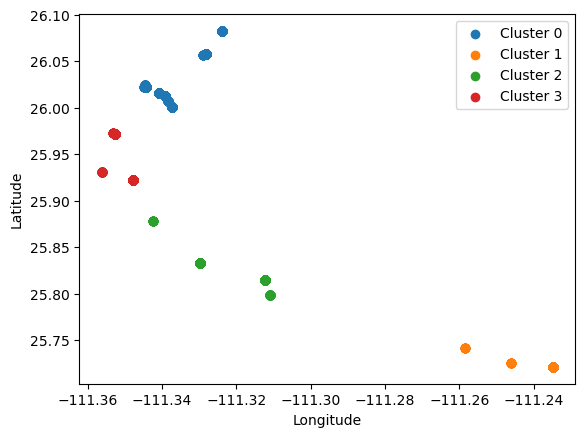

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd

df1 = pd.read_csv('Master_Dataset_LCK_2014-2020v2.csv')
df1["date"] = pd.to_datetime(df1["date"],format="%Y-%m-%d")
df1 = df1.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df1 = df1.dropna(subset=["date","temperature","ph","salinity","dis_oxy"])
df1 = df1.drop_duplicates()

Q1 = df1['temperature'].quantile(0.25)
Q3 = df1['temperature'].quantile(0.75)
IQR = Q3 - Q1
tp_lower_bound = Q1 - 2.0 * IQR
tp_upper_bound = Q3 + 2.0 * IQR
df1 = df1[(df1['temperature'] >= tp_lower_bound) & (df1['temperature'] <= tp_upper_bound)]

Q1 = df1['dis_oxy'].quantile(0.25)
Q3 = df1['dis_oxy'].quantile(0.75)
IQR = Q3 - Q1
dis_lower_bound = Q1 - 2.0 * IQR
dis_upper_bound = Q3 + 2.0 * IQR
df1 = df1[(df1['dis_oxy'] >= dis_lower_bound) & (df1['dis_oxy'] <= dis_upper_bound)]

Q1 = df1['ph'].quantile(0.25)
Q3 = df1['ph'].quantile(0.75)
IQR = Q3 - Q1
ph_lower_bound = Q1 - 2.0 * IQR
ph_upper_bound = Q3 + 2.0 * IQR

df1["Temperature Category"] = ""
df1.loc[df1["temperature"] > 23, "Temperature Category"] = "Hot"
df1.loc[(df1["temperature"] >= 19) & (df1["temperature"] <= 23), "Temperature Category"] = "Warm"
df1.loc[df1["temperature"] < 19, "Temperature Category"] = "Cold"

import numpy as np
from sklearn.cluster import KMeans

# Assuming you have a DataFrame named 'df' with 'latitude' and 'longitude' columns

# Feature engineering: convert latitude and longitude to radians
df1['lat_rad'] = np.radians(df1['latitude'])
df1['lon_rad'] = np.radians(df1['longitude'])

# Combine latitude and longitude into a feature matrix
X = df1[['lat_rad', 'lon_rad']]

# Choose the number of clusters (K)
k = 4  # You can adjust this based on your data and needs

# Apply K-Means clustering
kmeans = KMeans(n_clusters=k,n_init=10)
df1['cluster'] = kmeans.fit_predict(X)

# Visualize the clusters
import matplotlib.pyplot as plt

# Plot the data points with different colors for each cluster
for cluster_id in range(k):
    plt.scatter(df1[df1['cluster'] == cluster_id]['longitude'], df1[df1['cluster'] == cluster_id]['latitude'], label=f'Cluster {cluster_id}')

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [37]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score,f1_score,classification_report, roc_curve,roc_auc_score
from sklearn.datasets import load_digits
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# Setting SEED for reproducibility
SEED = 23
dfp=df1
accuracys_gbc=[]
accuracys_dt=[]
accuracys_rf=[]
accuracys_lr=[]
gbcm=[]
dtm=[]
rfm=[]
lrm=[]

for k in range(len(df1["cluster"].unique())):
    # Importing the dataset 
    dfk=""
    dfk = df1.loc[df1["cluster"]==k,]
    X = dfk[["ph","dis_oxy","salinity"]]
    X = pd.DataFrame(X,columns=["ph","dis_oxy","salinity"])
    Y = dfk["Temperature Category"]

    # Splitting dataset
    train_X, test_X, train_y, test_y = train_test_split(X, Y, 
                                                        test_size = 0.25, 
                                                        random_state = 123)
    ##
    
    gbc = GradientBoostingClassifier(n_estimators=1000,
                                     learning_rate=0.05,
                                     random_state=100,
                                     max_features=5 )
    gbcm.append(gbc)
    gbc.fit(train_X, train_y)
    pred_y = gbc.predict(test_X)
    acc = accuracy_score(test_y, pred_y)
    accuracys_gbc.append(acc)
    
    d=DecisionTreeClassifier()
    d.fit(train_X,train_y)
    dtm.append(d)
    pred_y=d.predict(test_X)
    acc = accuracy_score(test_y, pred_y)
    accuracys_dt.append(acc)
    
    rf=RandomForestClassifier()
    rf.fit(train_X,train_y)
    rfm.append(rf)
    pred_y=rf.predict(test_X)
    acc = accuracy_score(test_y, pred_y)
    accuracys_rf.append(acc)
    
    lr=LogisticRegression(solver='lbfgs',max_iter=1000)
    lr.fit(train_X,train_y)
    lrm.append(lr)
    pred_y=lr.predict(test_X)
    acc = accuracy_score(test_y, pred_y)
    accuracys_lr.append(acc)
    
print(accuracys_gbc,"\n average: ",st.mean(accuracys_gbc),"\n")
print(accuracys_dt,"\n average: ",st.mean(accuracys_dt),"\n")
print(accuracys_rf,"\n average: ",st.mean(accuracys_rf),"\n")
print(accuracys_lr,"\n average: ",st.mean(accuracys_lr),"\n")

[0.8553846153846154, 0.7796610169491526, 0.7735849056603774, 0.8789808917197452] 
 average:  0.8219028574284727 

[0.8276923076923077, 0.7627118644067796, 0.7924528301886793, 0.8343949044585988] 
 average:  0.8043129766865913 

[0.8553846153846154, 0.7627118644067796, 0.7735849056603774, 0.8853503184713376] 
 average:  0.8192579259807775 

[0.6153846153846154, 0.6610169491525424, 0.6415094339622641, 0.6878980891719745] 
 average:  0.651452271917849 



In [13]:
import os, time
from influxdb_client_3 import InfluxDBClient3, Point

token = "bIq_bcybf3PNahATbM75_rx2-koAqxmMypxSjVbmy80NXzK5eXaeXGYRttGmzdN1KdsEtdR0c-QLPNGHAJ9c-Q=="
org = "None"
host = "https://us-east-1-1.aws.cloud2.influxdata.com"

client = InfluxDBClient3(host=host, token=token, org=org)

In [19]:
database="Maldives Ocean Hackathon"

data = {
  "point200000": {
    "location": "LOL",
    "species": "bees",
    "count": 28,
  }
}

for key in data:
  point = (
    Point("census")
    .tag("location", data[key]["location"])
    .field(data[key]["species"], data[key]["count"])
  )
  client.write(database=database, record=point)
  time.sleep(1) # separate points by 1 second

print("Complete. Return to the InfluxDB UI.")


Complete. Return to the InfluxDB UI.


In [20]:
query = """SELECT *
FROM 'census'
WHERE time >= now() - interval '24 hours'
AND ('bees' IS NOT NULL OR 'ants' IS NOT NULL)"""

# Execute the query
table = client.query(query=query, database="Maldives Ocean Hackathon", language='sql') 

# Convert to dataframe
df = table.to_pandas().sort_values(by="time")
print(df)

    ants  bees        location                          time
2    NaN  23.0         Klamath 2023-10-12 14:51:20.075229968
13  30.0   NaN        Portland 2023-10-12 14:51:21.476532720
3    NaN  28.0         Klamath 2023-10-12 14:51:22.804274657
14  32.0   NaN        Portland 2023-10-12 14:51:24.094972364
4    NaN  29.0         Klamath 2023-10-12 14:51:25.381186132
15  40.0   NaN        Portland 2023-10-12 14:51:26.721776388
5    NaN  23.0         Klamath 2023-10-12 14:51:46.722152314
16  30.0   NaN        Portland 2023-10-12 14:51:48.009907421
6    NaN  28.0         Klamath 2023-10-12 14:51:49.296206665
17  32.0   NaN        Portland 2023-10-12 14:51:50.590905749
7    NaN  29.0         Klamath 2023-10-12 14:51:51.881004988
18  40.0   NaN        Portland 2023-10-12 14:51:53.171187640
8    NaN  23.0         Klamath 2023-10-12 14:55:57.011261788
19  30.0   NaN        Portland 2023-10-12 14:55:58.297298156
9    NaN  28.0         Klamath 2023-10-12 14:55:59.605925980
20  32.0   NaN        Po